# Example: div-k-grad-u inverse problem
# WORK IN PROGRESS, DO NOT USE

In [24]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt
from ufl import replace
from scipy.optimize import minimize
import scipy.sparse as sps

In [4]:
def gaussian_expression(magnitude, mu, sigma_scalar):
    # m*G, where G is gaussian with mean mu and standard deviation sigma
    return Expression('m*exp(-(pow(x[0]-mu_x,2)+pow(x[1]-mu_y,2))/s)',
                      m=magnitude, mu_x=mu[0], mu_y=mu[1], s=sigma_scalar, degree=5)

$$-\nabla \cdot (e^{\gamma} \nabla u) = f $$
$$ -v \nabla \cdot (e^{\gamma} \nabla u) = v f $$
Integrating over $ \Omega $

$$ -\int_{\Omega} \, v \nabla \cdot (e^{\gamma} \nabla u) \, \mathrm{d}x = \int_\Omega vf \mathrm{d} x $$

Integrating by parts using Stokes theorem

$$ -\int_{\partial \Omega}v e^{\gamma} \nabla u \cdot \hat{n} \, \mathrm{d}S \ + \int_{\Omega} \,e^{\gamma} \nabla v \cdot \nabla u \,\mathrm{d}x  = \int_{\Omega} vf \mathrm{d} x $$

Robin Boundary Conditions

$$ u + e^{\gamma} \nabla u \cdot \hat{n} = 0 $$

$$ \int_{\partial \Omega}v u  \, \mathrm{d}S \ + \int_{\Omega} \,e^{\gamma} \nabla v \cdot \nabla u \,\mathrm{d}x  = \int_{\Omega} vf \mathrm{d} x $$

The first term is akin to the boundary mass matrix and $\gamma$ is logarithm of conductivity.

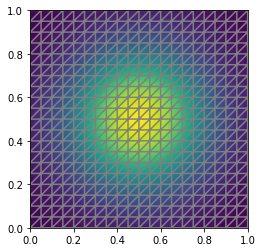

In [10]:
mesh_n = 20
mesh = UnitSquareMesh(mesh_n, mesh_n)
V = FunctionSpace(mesh, 'CG', 1)
plot(mesh)
g = gaussian_expression(1.0, np.array([0.5, 0.5]), 0.1)
plot(g,mesh=mesh)
f = gaussian_expression(1.0, np.array([0.5, 0.5]), 0.1)

<class 'numpy.ndarray'>


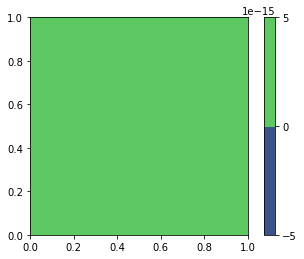

In [37]:
u_trial = TestFunction(V)
v_test = TrialFunction(V)
gamma = Function(V)

lhs_form = u_trial * v_test * ds + exp(gamma)* inner(grad(u_trial), grad(v_test)) * dx
rhs_form = v_test * f * dx
#gamma.vector()[:] = np.random.randn(V.dim())
# Gives the coordinates --- Need this order.

numpy_coordinates = V.tabulate_dof_coordinates()
print(type(numpy_coordinates))
#gamma.vector()[0]
cm = plot(gamma)
plt.colorbar(cm)

In [25]:
def csr_fenics2scipy(A_fenics):
    # Usage:
    #   https://github.com/NickAlger/nalger_helper_functions/blob/master/jupyter_notebooks/csr_conversions.ipynb
    ai, aj, av = as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

[0.06126651 0.06437809 0.06437809 0.06743228 0.06761027 0.06743228
 0.07040599 0.07082048 0.07082048 0.07040599 0.07324282 0.07395992
 0.07421238 0.07395992 0.07324282 0.07586692 0.07696265 0.07755308
 0.07755308 0.07696265 0.07586692 0.0781908  0.07974569 0.08076738
 0.08112383 0.08076738 0.07974569 0.0781908  0.08012343 0.08221424
 0.08376154 0.08458651 0.08458651 0.08376154 0.08221424 0.08012343
 0.08157946 0.08426975 0.08642858 0.08783383 0.08832225 0.08783383
 0.08642858 0.08426975 0.08157946 0.08248872 0.08581966 0.0886569
 0.09074274 0.09185153 0.09185153 0.09074274 0.0886569  0.08581966
 0.08248872 0.08280476 0.08678785 0.09034133 0.09318417 0.09503241
 0.09567458 0.09503241 0.09318417 0.09034133 0.08678785 0.08280476
 0.08251082 0.08712392 0.09139506 0.09503585 0.09771511 0.09914062
 0.09914062 0.09771511 0.09503585 0.09139506 0.08712392 0.08251082
 0.08162201 0.08680975 0.09176056 0.09619652 0.09975705 0.1020774
 0.10288463 0.1020774  0.09975705 0.09619652 0.09176056 0.086809

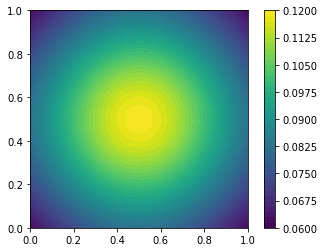

In [33]:
#Assemble
A = assemble(lhs_form)
b = assemble(rhs_form)
u = Function(V)
A_solver = LUSolver(A)
A_solver.solve(u.vector(), b)
cm = plot(u)
plt.colorbar(cm)
u_numpy = u.vector()[:]
print(u_numpy)

In [5]:
def equally_spaced_points_on_boundary_of_unit_square(num_pts_per_side):
    ss = np.linspace(0., 1., num_pts_per_side)
        
    xx_bot = ss
    yy_bot = np.zeros(len(xx_bot))
    pts_bot = np.array([xx_bot, yy_bot]).T
    
    xx_top = ss
    yy_top = np.ones(len(xx_top))
    pts_top = np.array([xx_top, yy_top]).T

    yy_left = ss[1:-1]
    xx_left = np.zeros(len(yy_left))
    pts_left = np.array([xx_left, yy_left]).T
    
    yy_right = ss[1:-1]
    xx_right = np.ones(len(yy_right))
    pts_right = np.array([xx_right, yy_right]).T
    
    return np.vstack([pts_bot, pts_top, pts_left, pts_right])

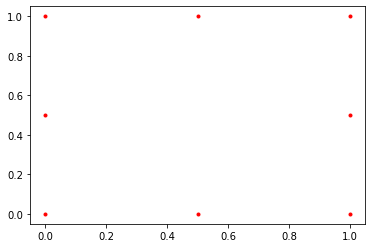

In [6]:
pts = equally_spaced_points_on_boundary_of_unit_square(3)
plt.plot(pts[:,0], pts[:,1], '.r')

In [7]:
def sum_of_partial_directional_derivatives(form, uu, duu):
    # Same as   derivative(form, uu[0], duu[0]) 
    #         + derivative(form, uu[1], duu[1]) 
    #         + ... 
    #         + derivative(form, uu[-1], duu[-1])
    dform = derivative(form, uu[0], duu[0])
    for u, du in zip(uu[1:], duu[1:]):
        dform += derivative(form, u, du)
    return dform

In [8]:
class PoissonInverseProblem:
    def __init__(me, function_space_V, m_true, m0_vec=None, tau=0.1, alpha=1.0, source_points_per_side=3):
        me.V = function_space_V
        me.m_true = m_true
        me.tau = tau   #Regularization = (\tau I + \Delta)^{-2}
        me.alpha = alpha # Regularization parameter. Overall regularization = alpha * (\tau I + \Delta)^{-2}
        me.source_points_per_side=source_points_per_side
        
        
        me.m = Function(me.V) #Parameter
        if m0_vec == None:
            pass
        else:
            me.m.vector()[:] = m0_vec # Parameter
        
        f = Constant(0.0) # Right hand side
        
        # Boundary conditions for each experiment
        me.source_points = equally_spaced_points_on_boundary_of_unit_square(me.source_points_per_side)
        me.sigma = 1./source_points_per_side
        me.num_experiments = me.source_points.shape[0]
        me.all_uD = list()
        for k in range(me.num_experiments):
            me.all_uD.append(gaussian_expression(1.0, me.source_points[k,:], me.sigma)) # Dirichlet data
            
        
#         me.u_D = gaussian_expression(1.0, np.array([0.8, 0.0]), 0.02) # Dirichlet data
        
        me.all_u = [Function(me.V) for _ in range(me.num_experiments)] # State variables
        me.all_p = [Function(me.V) for _ in range(me.num_experiments)] # Adjoint variables
        
        me.dm = Function(me.V) # Function to apply the Hessian to (dm -> Hdm)
        
        me.all_icru = [Function(me.V) for _ in range(me.num_experiments)] # incremental state variables
        me.all_icrp = [Function(me.V) for _ in range(me.num_experiments)] # incremental adjoint variables
        
        # Set up dictionary to specify which functions are derivatives of other functions
        me.derivatives_dictionary = dict()
        me.derivatives_dictionary[me.m] = me.dm
        
        for u, icru in zip(me.all_u, me.all_icru):
            me.derivatives_dictionary[u] = icru
            
        for p, icrp in zip(me.all_p, me.all_icrp):
            me.derivatives_dictionary[p] = icrp
        
        
        ####    Make forward (state) equation form    ####
        
        
#       AFTER:
        me.all_forward_form_base = [(inner(exp(me.m) * grad(u), grad(p))*dx) - (f * p * dx)
                                    for u, p in zip(me.all_u, me.all_p)]


        me.all_forward_form = [replace(fb, {u:TrialFunction(V), p:TestFunction(V)})
                              for fb, u, p in zip(me.all_forward_form_base, me.all_u, me.all_p)]
        
      
        me.all_forward_lhs = [lhs(f) for f in me.all_forward_form]
        me.all_forward_rhs = [rhs(f) for f in me.all_forward_form]
        
        on_boundary_func = lambda x, on_boundary: on_boundary
        
        me.all_bc = [DirichletBC(me.V, uD, on_boundary_func) for uD in me.all_uD]

        me.all_homogenized_bc = [DirichletBC(me.V, Constant(0.0), on_boundary_func) for _ in range(me.num_experiments)]
        me.G = None #Forward operator
        me.G_Solver = None 
        
        
        ####    Make objective function form    ####
        me.all_u_true = [Function(me.V) for _ in range(me.num_experiments)]
                
        nu = FacetNormal(me.V.mesh())

        me.all_misfit_form = [pow(inner(nu, exp(me.m) * grad(u - u_true)), 2) * ds
                             for u, u_true in zip(me.all_u, me.all_u_true)]
        
        #Mass matrix computation
        me.mass_form = TrialFunction(me.V) * TestFunction(me.V) * dx
        me.M = assemble(me.mass_form)
        me.M_solver = LUSolver(me.M)
        
        
        #Regularization computation
        me.regularization_form = 0.5 * (inner(grad(me.m), grad(me.m)) * dx + tau * me.m * me.m * dx)
        me.regularization_gradient_form = derivative(me.regularization_form, me.m, TestFunction(me.V))
        me.regularization_hessian_form = derivative(me.regularization_gradient_form, me.m, TrialFunction(me.V))
        me.R = None #Regularization matrix
        
        # Lagrangian Form
        me.all_lagrangian_form = [misfit_form + forward_form_base 
                                  for misfit_form, forward_form_base
                                  in zip(me.all_misfit_form, me.all_forward_form_base)]

        # Gradient form
        me.all_gradient_form = [derivative(lagrangian_form, me.m, TestFunction(me.V))
                                for lagrangian_form in me.all_lagrangian_form]
        
        # Adjoint form
        me.all_adjoint_form_base = [derivative(lagrangian_form, u, TestFunction(me.V))
                                    for lagrangian_form, u in zip(me.all_lagrangian_form, me.all_u)]
        
        me.all_adjoint_form = [replace(adjoint_form_base, {p:TrialFunction(me.V)})
                               for adjoint_form_base, p in zip(me.all_adjoint_form_base, me.all_p)]
        
        me.all_adjoint_lhs = [lhs(adjoint_form) for adjoint_form in me.all_adjoint_form]
        me.all_adjoint_rhs = [rhs(adjoint_form) for adjoint_form in me.all_adjoint_form]
        me.Gt = None
        me.Gt_solver = None
        me.adjoint_is_computed = False
        
        # Hessian Forms
        
        # Hessian vector product is directional derivative of gradient
        me.all_misfit_hessian_form = [me.total_derivative_of_form(gradient_form)
                                      for gradient_form in me.all_gradient_form]
        
        
        # Incremental forward equation is total derivative of forward equation
        me.all_incremental_forward_form_base = [me.total_derivative_of_form(forward_form_base)
                                                for forward_form_base in me.all_forward_form_base]

        me.all_incremental_forward_form = [replace(ifb, {icru:TrialFunction(me.V), p:TestFunction(me.V)})
                                           for ifb, p, icru in zip(me.all_incremental_forward_form_base,
                                                                   me.all_p, me.all_icru)]
    
        me.all_incremental_forward_rhs = [rhs(iff) for iff in me.all_incremental_forward_form]
        
        # Incremental adjoint equation is total derivative of adjoint equation
        me.all_incremental_adjoint_form_base = [me.total_derivative_of_form(adjoint_form_base)
                                                   for adjoint_form_base in me.all_adjoint_form_base]

        me.all_incremental_adjoint_form = [replace(iafb, {icrp:TrialFunction(me.V)})
                                          for iafb, icrp in zip(me.all_incremental_adjoint_form_base, me.all_icrp)]
    
        me.all_incremental_adjoint_rhs = [rhs(iaf) for iaf in me.all_incremental_adjoint_form]
        
        
        #Solving for u_true
        
        m0_vectcopy = me.m.vector().copy()
        me.update_m(me.m_true.vector().copy(), compute_adjoint=False)
        
        for u, u_true in zip(me.all_u, me.all_u_true):
            u_true.vector()[:] = u.vector()[:].copy()
            
        me.update_m(m0_vectcopy)
        
        
    def total_derivative_of_form(me, form):
        uu = list()
        duu = list()
        for u in me.derivatives_dictionary.keys():
            if u in form.coefficients():
                uu.append(u)
                duu.append(me.derivatives_dictionary[u])
        if uu:
            dform = sum_of_partial_directional_derivatives(form, uu, duu)
        else:
            dform = Constant(0.0) * form
        return dform
    
                                     
    def update_m(me, new_m_vector, compute_adjoint=True):
        m_has_changed = (norm(new_m_vector - me.m.vector()) > 1e-15)
        if m_has_changed:
            me.m.vector()[:] = new_m_vector
            me.make_forward_and_adjoint_solvers()
            me.R = assemble(me.regularization_hessian_form)
            me.solve_forward()
            me.adjoint_is_computed = False
            
        if (compute_adjoint and (not me.adjoint_is_computed)):
            me.solve_adjoint()
            me.adjoint_is_computed = True


    def solve_forward(me):
        ulist = [Function(me.V) for _ in range(me.num_experiments)]
        i = 0
        for u, forward_rhs, bc in zip(me.all_u, me.all_forward_rhs, me.all_bc):
            b = assemble(forward_rhs)
            bc.apply(b)
            me.G_solver.solve(u.vector(), b)
            ulist[i]=u.vector()[:]
            i=i+1
        return ulist
        
            
    
    def make_forward_and_adjoint_solvers(me):
        me.G = assemble(me.all_forward_lhs[0])
        me.all_bc[0].apply(me.G)
        me.G_solver = LUSolver(me.G)
        
        me.Gt = assemble(me.all_adjoint_lhs[0])
        me.all_homogenized_bc[0].apply(me.Gt)
        me.Gt_solver = LUSolver(me.Gt)
#         me.Gt_solver = me.G_solver
        
        
    def compute_data_misfit(me):
        data_misfit = 0.0
        for misfit_form in me.all_misfit_form:
            data_misfit += assemble(misfit_form)
        return data_misfit
    
    def compute_objective(me):
        return me.compute_data_misfit() +  me.alpha*assemble(me.regularization_form)
    
    
    def solve_adjoint(me):
        for p, adjoint_rhs, homogenized_bc in zip(me.all_p, me.all_adjoint_rhs, me.all_homogenized_bc):
            b = assemble(adjoint_rhs)
            homogenized_bc.apply(b)
            me.Gt_solver.solve(p.vector(), b)
        
    def compute_riesz_representative(me, v_dual):
        v_riesz = Function(me.V).vector()
        me.M_solver.solve(v_riesz, v_dual)
        return v_riesz
        
    
    def compute_misfit_gradient(me):
        misfit_gradient = assemble(me.all_gradient_form[0])
        for k in range(1, me.num_experiments):
            misfit_gradient += assemble(me.all_gradient_form[k])
        return misfit_gradient
    
    def compute_regularization_gradient(me):
        gr = me.alpha * assemble(me.regularization_gradient_form)
        return gr
    
    def compute_gradient(me):
        gr = me.compute_regularization_gradient()
        gd = me.compute_misfit_gradient()
        gr.axpy(1.0, gd)
        return gr
        
        
    def solve_incremental_forward(me):
        for icru, incremental_forward_rhs, homogenized_bc in zip(me.all_icru, 
                                                                 me.all_incremental_forward_rhs,
                                                                 me.all_homogenized_bc):
            b = assemble(incremental_forward_rhs)
            homogenized_bc.apply(b)
            me.G_solver.solve(icru.vector(), b)

    def solve_incremental_adjoint(me):
        for icrp, incremental_adjoint_rhs, homogenized_bc in zip(me.all_icrp, 
                                                                 me.all_incremental_adjoint_rhs,
                                                                 me.all_homogenized_bc):
            b = assemble(incremental_adjoint_rhs)
            homogenized_bc.apply(b)
    #     G_solver.solve_transpose(v.vector(), b)
            me.Gt_solver.solve(icrp.vector(), b) # symmetric
    
    def apply_data_misfit_hessian_to_vector(me, dm_vector):
        me.dm.vector()[:] = dm_vector
    
        me.solve_incremental_forward()
        me.solve_incremental_adjoint()
        
        Hdm_misfit = assemble(me.all_misfit_hessian_form[0]) 
        for k in range(1, me.num_experiments):
            Hdm_misfit += assemble(me.all_misfit_hessian_form[k])
        return Hdm_misfit
    
    def apply_regularization_hessian_to_vector(me, dm_vector):
        return me.alpha*me.R*dm_vector
        
    
    def apply_hessian_to_vector(me, dm_vector):
        Hdm_misfit = me.apply_data_misfit_hessian_to_vector(dm_vector)
        Hdm_regularization = me.apply_regularization_hessian_to_vector(dm_vector)
        
        Hdm = Hdm_misfit + Hdm_regularization

        return Hdm
        

PIP.compute_data_misfit()= 0.7512775226906862


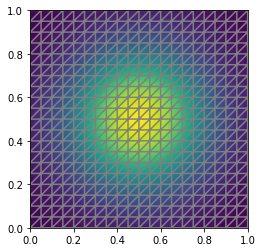

In [12]:
#m_true = Expression('x[1]*(1-x[1])*x[0]*(1-x[0])*sin(10*sqrt(pow(x[0],2) + pow(x[1],2)))', degree=5)
#m_true = Expression('((x[0]-0.5)*(x[0] - 0.5) + (x[1]-0.5)*(x[1]-0.5))<=0.04', degree=5)

# If you have multiple sources -- what is the solution? is it the sum of all the solutions?
#How to generate data?
m_true = gaussian_expression(1.0, np.array([0.5, 0.5]), 0.1)
m_true_function = project(m_true, V)
PIP = PoissonInverseProblem(V, m_true_function)
uval = PIP.solve_forward()

plot(mesh)
plot(m_true,mesh=mesh)

print('PIP.compute_data_misfit()=', PIP.compute_data_misfit())

8


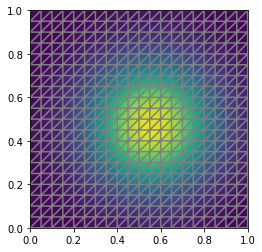

In [13]:
parameter_length = np.shape(PIP.m_true.vector()[:])[0]
#Generating data for Rohit

number_of_samples = 100
parameter_values = np.zeros((parameter_length, number_of_samples))
state_values = np.zeros((parameter_length, number_of_samples))
print(len(uval))

uval_total = np.zeros(parameter_length)


magnitude = np.random.uniform(0.8,1.2, 1)
mu = np.random.uniform(0.4,0.6, 2)
sigma_scalar = np.random.uniform(0.08, 0.12, 1)
m_sample = gaussian_expression(magnitude, mu, sigma_scalar)
m_sample_function = project(m_sample, V)
plot(mesh)
plot(m_sample_function,mesh=mesh)

In [9]:
for i in range(number_of_samples):
    print("Iteration number: ", i)
    magnitude = np.random.uniform(0.8,1.2, 1)
    mu = np.random.uniform(0.4,0.6, 2)
    sigma_scalar = np.random.uniform(0.08, 0.12, 1)
    m_sample = gaussian_expression(magnitude, mu, sigma_scalar)
    m_sample_function = project(m_sample, V)
    PIP = PoissonInverseProblem(V, m_sample_function)
    uval = PIP.solve_forward()
    uval_total = np.zeros(parameter_length)
    for j in range(PIP.num_experiments):
        uval_total = uval_total + np.asarray(uval[j])
    parameter_values[:,i] = PIP.m_true.vector()[:]
    state_values[:,i] = uval_total


    
    
    
    

# plt.figure()
# cm1 = plot(PIP.m_true)
# plt.title("true parameter")
# plt.colorbar(cm1)

# plt.figure()
# plot(PIP.m)
# plt.title('Current Parameter')


# for k in range(PIP.num_experiments):
#     plt.figure()
#     plot(PIP.all_u_true[k])
#     plt.title('true state ' + str(k))
    
#     plt.figure()
#     plot(PIP.all_u[k])
#     plt.title('Current State ' + str(k))

PIP.compute_data_misfit()= 0.7512775226906862
8
Iteration number:  0
Iteration number:  1
Iteration number:  2
Iteration number:  3
Iteration number:  4
Iteration number:  5
Iteration number:  6
Iteration number:  7
Iteration number:  8
Iteration number:  9
Iteration number:  10
Iteration number:  11
Iteration number:  12
Iteration number:  13
Iteration number:  14
Iteration number:  15
Iteration number:  16
Iteration number:  17
Iteration number:  18
Iteration number:  19
Iteration number:  20
Iteration number:  21
Iteration number:  22
Iteration number:  23
Iteration number:  24
Iteration number:  25
Iteration number:  26
Iteration number:  27
Iteration number:  28
Iteration number:  29
Iteration number:  30
Iteration number:  31
Iteration number:  32
Iteration number:  33
Iteration number:  34
Iteration number:  35
Iteration number:  36
Iteration number:  37
Iteration number:  38
Iteration number:  39
Iteration number:  40
Iteration number:  41
Iteration number:  42
Iteration number

In [10]:
print(np.shape(state_values))
print(np.shape(parameter_values))
np.save('parameter_values', parameter_values)
np.save('state_values', state_values)

(441, 100)
(441, 100)


In [11]:

pval = np.load('parameter_values.npy')
print(pval[:,0])

plt.figure()
cm1 = plot(pval[:,0])
plt.title("sample parameter")
plt.colorbar(cm1)

sval = np.load('state_values.npy')

plt.figure()
cm1 = plot(sval[:,0])
plt.title("corresponding state")
plt.colorbar(cm1)

[0.00515814 0.00831594 0.00797379 0.01271455 0.01271397 0.01168973
 0.01865026 0.01946098 0.0186614  0.01644138 0.02622446 0.02854845
 0.02856257 0.02625003 0.02216726 0.03534821 0.04014807 0.04190758
 0.04018431 0.03539841 0.02864972 0.04567423 0.05412461 0.05894367
 0.05896776 0.05419625 0.0457599  0.03549525 0.05657386 0.06994793
 0.07947483 0.08295149 0.07954139 0.07006945 0.05670702 0.04215586
 0.06717382 0.08665726 0.10272363 0.11186177 0.11190941 0.10285337
 0.08684342 0.06736566 0.04799357 0.07645798 0.10291654 0.12727977
 0.14460652 0.15093443 0.14472916 0.12749493 0.10317947 0.0767168
 0.0523774  0.08342244 0.11716977 0.15118084 0.17920194 0.19514551
 0.19522808 0.17942974 0.15150111 0.11751626 0.0837515  0.05479482
 0.08725271 0.12787813 0.17214025 0.21288556 0.24186744 0.25245088
 0.24207229 0.21324623 0.17257877 0.12830715 0.08764857 0.0549501
 0.08748019 0.13379109 0.18789551 0.24243673 0.28737231 0.31293934
 0.31307183 0.28773752 0.24295004 0.18845493 0.13429254 0.087932

RuntimeError: Don't know how to plot given object:
  [0.00515814 0.00831594 0.00797379 0.01271455 0.01271397 0.01168973
 0.01865026 0.01946098 0.0186614  0.01644138 0.02622446 0.02854845
 0.02856257 0.02625003 0.02216726 0.03534821 0.04014807 0.04190758
 0.04018431 0.03539841 0.02864972 0.04567423 0.05412461 0.05894367
 0.05896776 0.05419625 0.0457599  0.03549525 0.05657386 0.06994793
 0.07947483 0.08295149 0.07954139 0.07006945 0.05670702 0.04215586
 0.06717382 0.08665726 0.10272363 0.11186177 0.11190941 0.10285337
 0.08684342 0.06736566 0.04799357 0.07645798 0.10291654 0.12727977
 0.14460652 0.15093443 0.14472916 0.12749493 0.10317947 0.0767168
 0.0523774  0.08342244 0.11716977 0.15118084 0.17920194 0.19514551
 0.19522808 0.17942974 0.15150111 0.11751626 0.0837515  0.05479482
 0.08725271 0.12787813 0.17214025 0.21288556 0.24186744 0.25245088
 0.24207229 0.21324623 0.17257877 0.12830715 0.08764857 0.0549501
 0.08748019 0.13379109 0.18789551 0.24243673 0.28737231 0.31293934
 0.31307183 0.28773752 0.24295004 0.18845493 0.13429254 0.08793205
 0.05282378 0.08407638 0.13418634 0.19660683 0.26466669 0.32731139
 0.37187083 0.38814282 0.37218575 0.32786618 0.26533907 0.19727687
 0.13474138 0.08456672 0.04867673 0.07745877 0.12901479 0.19720999
 0.27698021 0.3573765  0.42361642 0.46130462 0.46149994 0.42415465
 0.3581339  0.27780113 0.19796719 0.12959791 0.07796533 0.04299749
 0.06840664 0.11891062 0.18963008 0.27787324 0.3740585  0.46259634
 0.5255727  0.5485702  0.52601785 0.46338018 0.37501004 0.27881446
 0.19044016 0.11949308 0.06890539 0.0364077  0.05791044 0.10506342
 0.17479677 0.26723486 0.37531992 0.48426191 0.57401939 0.62508852
 0.62535316 0.57474881 0.48528782 0.37643408 0.26825322 0.1756192
 0.10561732 0.05837866 0.02955099 0.04699377 0.08898797 0.15445701
 0.2463699  0.36100416 0.48596734 0.60099255 0.68280961 0.71268721
 0.68338789 0.60201102 0.48720303 0.36222919 0.24741319 0.15525061
 0.08949015 0.04741368 0.02299178 0.03655478 0.07225549 0.13083589
 0.21773625 0.33286725 0.46750088 0.60319861 0.71500078 0.77861249
 0.77894214 0.71590931 0.60447664 0.46888803 0.33413834 0.21875035
 0.13156573 0.07268755 0.03691584 0.01714721 0.02728103 0.05623012
 0.10624469 0.18446749 0.2942242  0.43112797 0.58036369 0.7177318
 0.81544109 0.85112217 0.81613171 0.71894805 0.58183957 0.43259029
 0.29547268 0.18540559 0.10688034 0.05659875 0.02754663 0.01227122
 0.01929382 0.04199987 0.08269507 0.14981759 0.24930608 0.38113464
 0.53528941 0.69066362 0.81867707 0.89151248 0.89188992 0.81971734
 0.6921269  0.53687792 0.38258917 0.25047049 0.15064109 0.08323539
 0.04224083 0.01973456 0.0082963  0.02996651 0.06172441 0.11663573
 0.20250647 0.3229967  0.47328816 0.63711756 0.78791875 0.89518292
 0.9343532  0.89594108 0.78925394 0.63873776 0.4748935  0.32436719
 0.20353665 0.11733218 0.06213428 0.03023793 0.01348147 0.04407934
 0.08707173 0.15767808 0.26240332 0.40115318 0.56340566 0.7269406
 0.86167791 0.93833893 0.93873621 0.86277281 0.72848079 0.5650774
 0.4026849  0.26362596 0.15855567 0.08760015 0.04448507 0.02068029
 0.06220576 0.11772255 0.20434854 0.32594603 0.47760706 0.64293208
 0.79510937 0.90335246 0.94288021 0.90411753 0.79645678 0.64456694
 0.47922759 0.32732694 0.20539595 0.11839672 0.06272306 0.03043916
 0.08414899 0.15258097 0.25387324 0.38812394 0.54510406 0.70332736
 0.83368793 0.90785882 0.90824318 0.83474729 0.70481741 0.546722
 0.38960382 0.25506447 0.1533979  0.08478095 0.04294684 0.10911739
 0.18957892 0.30235014 0.44304033 0.59639848 0.73756202 0.83797088
 0.87463778 0.83868059 0.73881184 0.59791534 0.44454203 0.30363779
 0.19052268 0.1098545  0.05808363 0.13563466 0.22580281 0.3451844
 0.48480202 0.62552141 0.74146097 0.80742679 0.80776862 0.74240313
 0.62684676 0.48624009 0.34650516 0.22684093 0.13645411 0.07530188
 0.1616141  0.25782116 0.37778096 0.50855048 0.62892154 0.71454045
 0.74580657 0.71514566 0.6299872  0.50984379 0.37906335 0.25890701
 0.16248186 0.09358094 0.18459536 0.28220054 0.39634831 0.51139011
 0.60617703 0.66010671 0.6603863  0.60694702 0.51247429 0.39752299
 0.28327876 0.18546967 0.11148065 0.20211399 0.29610609 0.3986228
 0.49296863 0.56008151 0.58458851 0.56055552 0.49380521 0.39963288
 0.2971202  0.20295084 0.12730433 0.2121325  0.29784283 0.38432225
 0.4555489  0.49608007 0.49628954 0.45612934 0.38513127 0.29874349
 0.21289178 0.13935402 0.21342951 0.28719529 0.3552035  0.40355204
 0.42121225 0.4038954  0.35579931 0.28794722 0.21408052 0.1462277
 0.20584455 0.26547146 0.31470768 0.34269896 0.34284613 0.31510112
 0.26605761 0.20636958 0.14708718 0.19031065 0.23523866 0.26729185
 0.27898141 0.26751268 0.23566038 0.1907061  0.14182612 0.16866577
 0.19982494 0.2176271  0.21771293 0.20009979 0.16894044 0.1310917
 0.1432952  0.16272011 0.1698582  0.16287415 0.14346753 0.1161535
 0.11670262 0.12702221 0.12709149 0.11679388 0.09865786 0.09110996
 0.09505782 0.09115039 0.08032745 0.06818743 0.06817405 0.06269693
 0.04894492 0.04693678 0.03343582]
and projection failed:
  'numpy.ndarray' object has no attribute 'ufl_domain'

<Figure size 432x288 with 0 Axes>

s= 1.0 , err_grad= -0.8962940923462854 , err_hess= 0.8881470609554737
s= 0.1 , err_grad= -0.172479271031743 , err_hess= 0.16273462763955424
s= 0.01 , err_grad= -0.018343397436865166 , err_hess= 0.017167383377299384
s= 0.001 , err_grad= -0.0018454863743243596 , err_hess= 0.0017257030481576782
s= 0.0001 , err_grad= -0.00018466035498904606 , err_hess= 0.0001726605225528428
s= 1e-05 , err_grad= -1.846700495893102e-05 , err_hess= 1.7267081937462592e-05
s= 1e-06 , err_grad= -1.8456068205491663e-06 , err_hess= 1.7258012448119354e-06
s= 1e-07 , err_grad= -1.8494398339342116e-07 , err_hess= 1.7182859669006516e-07
s= 1e-08 , err_grad= -9.175453064926671e-08 , err_hess= 5.321510195140643e-07
s= 1e-09 , err_grad= 3.828901130411266e-06 , err_hess= 6.281010454967962e-06
s= 1e-10 , err_grad= -3.670811076215719e-06 , err_hess= 4.1314602861467904e-05
s= 1e-11 , err_grad= 0.00020688365798669084 , err_hess= 0.00037898606130249384
s= 1e-12 , err_grad= 0.0014638828276330917 , err_hess= 0.003868681132982537

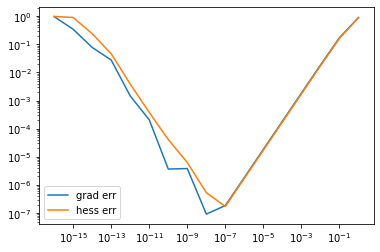

In [42]:
m0 = Expression('cos(x[0]) + x[1]', degree=5)
m0_vector = project(m0, V).vector()

PIP.update_m(m0_vector)

dmE = Expression('sin(x[1]) + x[1]*x[0]', degree=5)
dm_vector = project(dmE, V).vector()


# m0_numpy = np.random.randn(V.dim()) # error big: maybe because of quadrature error near boundary..?
# dm_numpy = np.random.randn(V.dim())

J0 = PIP.compute_objective()
grad0 = PIP.compute_gradient()
dJ = np.dot(grad0[:], dm_vector[:])
Hdm = PIP.apply_hessian_to_vector(dm_vector)

ss = np.logspace(-16, 0, 17)[::-1]
grad_errs = []
hess_errs = []
for k in range(len(ss)):
    s = ss[k]
    m1_vector = m0_vector + s * dm_vector
    PIP.update_m(m1_vector)
    J1 = PIP.compute_objective()
    grad1 = PIP.compute_gradient()
    #dJ1 = np.dot(grad1[:], dm_vector[:])
    
    dJ_diff = (J1 - J0)/s
    err_grad = (dJ - dJ_diff)/dJ_diff
    grad_errs.append(err_grad)
    
    Hdm_diff = (grad1 - grad0)/s
    err_hess = np.linalg.norm(Hdm_diff[:] - Hdm[:])/np.linalg.norm(Hdm_diff[:])
    hess_errs.append(err_hess)
    
    print('s=', s, ', err_grad=', err_grad, ', err_hess=', err_hess)
    #print('s=', s, ', err_grad=', err_grad)
    
plt.loglog(ss, np.abs(grad_errs))
plt.loglog(ss, np.abs(hess_errs))
plt.legend(['grad err', 'hess err'])
#plt.legend(['grad err'])

For the forward problem, we use the inhomogeneous Poisson problem with Dirichlet boundary conditions:
$$\begin{cases}
-\nabla \cdot e^m \nabla u = f & \text{in } \Omega \\
u = 0 & \text{on } \partial \Omega,
\end{cases}$$
where the domain is the unit square, $\Omega=[0,1]^2$, $n$ is the normal to $\partial \Omega$, the parameter is 
$$m(x) = 1.25 + \sin\left(10\|x\|\right),$$
and the source is
$$m(x) = \exp\left(-\frac{\left\|x - p_1\right\|^2}{\sigma^2}\right) + \exp\left(-\frac{\left\|x - p_2\right\|^2}{\sigma^2}\right)$$
where $p_1 = (0.75,0.75)$, $p_2 = (0.25, 0.1)$, $\sigma = 0.1$$.

The weak form for this problem may be written as seeking $u \in H^1_0(\Omega)$ which satisfies
$$0 = g(m,u,v) := \int_\Omega \nabla v \cdot e^m \nabla u dx - \int_\Omega f v dx$$
for all $v \in H^1_0(\Omega)$.

The data misfit function is
$$J_d(m) := \int_{\partial \Omega} \left(\nu \cdot e^m\nabla u(m) - \nu \cdot e^m \nabla u_\text{true}\right)^2 ds.$$

In [54]:

u_true = Function(V)
#u_true.vector()[:] = PIP.all_u.vector()[:].copy()
for u, u_true in zip(PIP.all_u, PIP.all_u_true):
        u_true.vector()[:] = u.vector()[:].copy()


nu = FacetNormal(mesh)

Jd_form = pow(inner(nu, exp(PIP.m) * grad(PIP.all_u - PIP.all_u_true)), 2) * ds
# Jd_form = pow(u - u_true, 2) * dx

def compute_data_misfit():
    return assemble(Jd_form)

Jd_true = compute_data_misfit()
print('Jd_true=', Jd_true)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [49]:
def update_m(new_m_vector):
    global G 
    global G_solver
    m.vector()[:] = new_m_vector[:].copy()
    G = assemble(forward_lhs)
    bc.apply(G)
    G_solver = LUSolver(G)

In [50]:
zero_vector = Function(V).vector()

PIP.update_m(zero_vector)
PIP.solve_forward()
Jd_0 = PIP.compute_data_misfit()

print('Jd_0=', Jd_0)

Jd_0= 0.0013684656489836473


In [29]:
cm1 = plot(u)
plt.colorbar(cm1)
plt.title('u at m=0')

NameError: name 'u' is not defined

The Lagrangian is
$$\mathcal{L}(m,u,v) := J(m,u,v) + g(m,u,v).$$
We seek an the adjoint variable $v \in H^1_0(\Omega)$ that solves the following adjoint equation
$$0 = a(m,u,v,\widetilde{u}) := \frac{\partial \mathcal{L}}{\partial u}(m,u,v,\widetilde{u}) = 0$$
for all $\widetilde{u} \in H^1_0(\Omega)$.

In [52]:
lagrangian_form = PIP.Jd_form + PIP.forward_form_base

adjoint_form0 = derivative(lagrangian_form, u, TestFunction(V))

adjoint_form = replace(adjoint_form0, {v:TrialFunction(V)})
adjoint_lhs = lhs(adjoint_form)
adjoint_rhs = rhs(adjoint_form)

Gt = assemble(adjoint_lhs)
bc.apply(Gt)
Gt_solver = LUSolver(Gt)

def solve_adjoint():
    b = assemble(adjoint_rhs)
    homogenized_bc.apply(b)
#     Gt_solver.solve(v.vector(), b)
    G_solver.solve(v.vector(), b) # symmetric

solve_adjoint()

AttributeError: 'PoissonInverseProblem' object has no attribute 'Jd_form'

Text(0.5, 1.0, 'adjoint v')

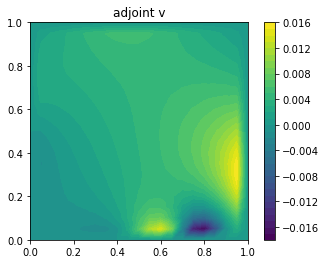

In [13]:
cm = plot(v)
plt.colorbar(cm)
plt.title('adjoint v')

The gradient dual function is given by 
$$g(h) = \frac{\partial \mathcal{L}}{\partial m}(m,u,v)h.$$
The Riesz representative of the gradient is given by the function $g_\text{Riesz}$ satisfying
$$\int_\Omega h g_\text{Riesz} dx = g(h)$$
for all $v$.

In [14]:
mass_form = TrialFunction(V) * TestFunction(V) * dx
M = assemble(mass_form)

M_solver = LUSolver(M)

In [15]:
gradient_form0 = derivative(lagrangian_form, m, TestFunction(V))

def compute_gradient(return_riesz_representative=False):
    g_dual_vector = assemble(gradient_form0)
    
    if return_riesz_representative:
        g_riesz_representative = Function(V)
        M_solver.solve(g_riesz_representative.vector(), g_dual_vector)
        return g_dual_vector, g_riesz_representative
    else:
        return g_dual_vector

g_dual0, g_riesz0 = compute_gradient(return_riesz_representative=True)

Text(0.5, 1.0, 'gradient (riesz representative)')

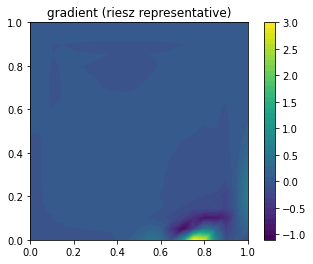

In [16]:
cm = plot(g_riesz0)
plt.colorbar(cm)
plt.title('gradient (riesz representative)')

In [17]:
m_original_numpy_vector = m.vector()[:].copy()

s = 1e-6
dm = Function(V)
dm.vector()[:] = np.random.randn(V.dim()) # perturb m a small bit

update_m(m_original_numpy_vector + s * dm.vector()[:])

solve_forward()
Jd_1 = compute_data_misfit()
solve_adjoint()
g_dual1, g_riesz1 = compute_gradient(return_riesz_representative=True)


update_m(m_original_numpy_vector) # Reset to original m

In [18]:
dJ_diff = (Jd_1 - Jd_0)/s

dJ = np.dot(g_dual0[:], dm.vector()[:])

err_grad = (dJ - dJ_diff)/dJ_diff
print('s=', s, ', err_grad=', err_grad)

s= 1e-06 , err_grad= -7.176519272968872e-05


# Hessian vector products

$$Hp = \frac{dg(m,u,v}{dm}p = \frac{\partial g}{\partial m}p + \frac{\partial g}{\partial u}\underbrace{\frac{du}{dm}p}_{\text{icru}} + \frac{\partial g}{\partial v}\underbrace{\frac{dv}{dm}p}_{\text{icrv}}$$

$$Hp = \frac{dg(m,u,v}{dm}p = \frac{\partial g}{\partial m}p + \frac{\partial g}{\partial u}u_p + \frac{\partial g}{\partial v}v_p$$

In [19]:
p = Function(V) # Function to apply the Hessian to (p -> Hp)
icru = Function(V) # incremental state
icrv = Function(V) # incremental adjoint

# Hessian vector product is directional derivative of gradient
hessian_form0 = (derivative(gradient_form0, m, p)
                + derivative(gradient_form0, u, icru)
                + derivative(gradient_form0, v, icrv))

Take derivative of forward equation to get incremental forward equation
$$0 = \mathcal{G}(m,u)$$
$$0 = \frac{d}{dm}\mathcal{G}(m,u)p = \frac{\partial \mathcal{G}}{\partial m} p + \frac{\partial \mathcal{G}}{\partial u} u_p$$

In [20]:
# Incremental forward equation is total derivative of forward equation
incremental_forward_form0 = (derivative(forward_form0, m, p) 
                             + derivative(forward_form0, u, icru))

incremental_forward_form = replace(incremental_forward_form0, {icru:TrialFunction(V)})
incremental_forward_rhs = rhs(incremental_forward_form)

take derivative of adjoint equation to get incremental adjoint equation
$$0 = \mathcal{A}(m,u,v)$$
$$0 = \frac{d}{dm}\mathcal{A}(m,u,v)p = \frac{\partial \mathcal{A}}{\partial m} p + \frac{\partial \mathcal{A}}{\partial u} u_p + \frac{\partial \mathcal{A}}{\partial v} v_p$$

In [21]:
# Incremental adjoint equation is total derivative of adjoint equation
incremental_adjoint_form0 = (derivative(adjoint_form0, m, p) 
                             + derivative(adjoint_form0, u, icru) 
                             + derivative(adjoint_form0, v, icrv))

incremental_adjoint_form = replace(incremental_adjoint_form0, {icrv:TrialFunction(V)})
incremental_adjoint_rhs = rhs(incremental_adjoint_form)

In [22]:
def solve_incremental_forward():
    b = assemble(incremental_forward_rhs)
    homogenized_bc.apply(b)
    G_solver.solve(icru.vector(), b)

In [23]:
def solve_incremental_adjoint():
    b = assemble(incremental_adjoint_rhs)
    homogenized_bc.apply(b)
#     G_solver.solve_transpose(v.vector(), b)
    G_solver.solve(icrv.vector(), b) # symmetric

In [24]:
def compute_hessian_vector_product(p_vector):
    p.vector()[:] = p_vector[:].copy()
    
    solve_incremental_forward()
    solve_incremental_adjoint()
    Hp = assemble(hessian_form0)
    return Hp

In [25]:
update_m(m_original_numpy_vector) # Reset to original m

solve_forward()
solve_adjoint()
Hdm = compute_hessian_vector_product(dm.vector()[:].copy())

In [26]:
Hdm_diff = (g_dual1[:] - g_dual0[:])/s
err_hess = np.linalg.norm(Hdm_diff - Hdm[:])/np.linalg.norm(Hdm_diff)
print('s=', s, ', err_hess=', err_hess)

s= 1e-06 , err_hess= 1.793916254111672e-06


## Regularization
$$J_R = \frac{1}{2} \left(\int_\Omega \|\nabla m\|^2 dx + 0.1 \int_\Omega m^2 dx\right)$$
$$\frac{d^2 J_R}{dm^2} = R = \Delta_N + 0.1 M$$
where $\Delta_N$ is discretized Neumann Laplacian, and $M$ is mass matrix.
$$M_{ij} := \int_\Omega \phi_i \phi_j dx$$
$$\left(\Delta_N\right)_{ij} := \int_\Omega \nabla \phi_i \cdot \nabla \phi_j dx$$

In [27]:
regularization_form0 = 0.5 * (inner(grad(m), grad(m)) * dx + 0.1 * m * m * dx)
regularization_gradient_form = derivative(regularization_form0, m, TestFunction(V))
regularization_hessian_form = derivative(regularization_gradient_form, m, TrialFunction(V))
R3 = assemble(regularization_hessian_form)

In [29]:
mass_form = TestFunction(V) * TrialFunction(V) * dx
M = assemble(mass_form)

neumann_laplacian_form = inner(grad(TestFunction(V)), grad(TrialFunction(V))) * dx
Delta_N = assemble(neumann_laplacian_form)

# regularization_form = neumann_laplacian_form + 0.1*mass_form
regularization_form = neumann_laplacian_form

def dirichlet_boundary(x, on_boundary):
    return on_boundary

bc_R = DirichletBC(V, Constant(0.0), dirichlet_boundary)

R0 = assemble(regularization_form)
# R = Delta_N + 0.1 * M

bc_R.apply(R0)
R = R0

In [30]:
z = Function(V)
z.vector()[:] = np.random.randn(V.dim())
w = R0 * z.vector() - R * z.vector()
np.linalg.norm(w[:])

0.0

In [31]:
z = Function(V)
z.vector()[:] = np.random.randn(V.dim())
w = R0 * z.vector() - R3 * z.vector()
np.linalg.norm(w[:])

15.12010740258796

## Optimize

In [37]:
a_reg = 1e-5 # regularization parameter

def fun(m_numpy):
    if True:
#     if np.linalg.norm(m_numpy - m.vector()[:]) > 1e-12:
        update_m(m_numpy)
#         m.vector()[:] = m_numpy
    solve_forward()
    return compute_data_misfit() + a_reg * assemble(regularization_form0)
    

def jac(m_numpy):
    if True:
#     if np.linalg.norm(m_numpy - m.vector()[:]) > 1e-12:
#         m.vector()[:] = m_numpy
        update_m(m_numpy)
        solve_forward()
    solve_adjoint()
    gd = compute_gradient()
    gr = a_reg * assemble(regularization_gradient_form)
    return gd[:] + gr[:]


dm = Function(V)
def hessp(m_numpy, dm_numpy):
    if True:
#     if np.linalg.norm(m_numpy - m.vector()[:]) > 1e-12:
#         m.vector()[:] = m_numpy
        update_m(m_numpy)
        solve_forward()
        solve_adjoint()
    dm.vector()[:] = dm_numpy
    Hd_dm = compute_hessian_vector_product(dm.vector())
    HR_dm = a_reg * (R3 * dm.vector())
    return Hd_dm[:] + HR_dm[:]

In [ ]:
dJ_diff

In [39]:
# soln = minimize(fun, np.zeros(V.dim()), args=(), method='trust-ncg', jac=jac, hessp=hessp, tol=1e-6, callback=None, options={})
soln = minimize(fun, m_true_vector[:], args=(), method='trust-ncg', jac=jac, hessp=hessp, tol=1e-6, callback=None, options={})

In [40]:
soln

     fun: 5.797813351486064e-08
     jac: array([-9.28218127e-11, -1.40529422e-09, -1.41374616e-09, -3.62537209e-09,
       -5.01327143e-09, -2.92685589e-09, -7.57019417e-09, -7.24696502e-09,
       -5.67666565e-09, -5.47756034e-09, -1.24417625e-08, -1.10826260e-08,
       -1.68365980e-09, -7.77784174e-09, -8.19569117e-09, -1.67904657e-08,
       -1.41237362e-08,  2.01741244e-10, -6.51345853e-10, -9.14465969e-09,
       -1.02561065e-08, -2.01449559e-08, -1.64666881e-08,  2.68183764e-09,
        6.40565635e-10,  9.65421357e-10, -9.02174642e-09, -1.05729583e-08,
       -2.28603368e-08, -1.81454374e-08,  4.81265788e-09,  2.59339398e-09,
        1.60049824e-09,  2.37235783e-09, -7.55323703e-09, -8.88455110e-09,
       -2.51940669e-08, -1.96594364e-08,  6.11996671e-09,  4.38278304e-09,
        2.66307665e-09,  2.48351864e-09,  2.79533151e-09, -4.87620943e-09,
       -5.26217583e-09, -2.63425497e-08, -2.02809363e-08,  7.29358227e-09,
        5.89367225e-09,  4.12797649e-09,  3.09392438e-09, 

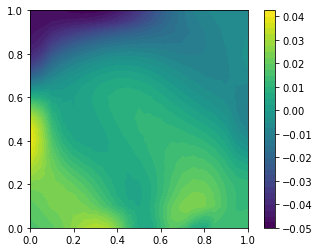

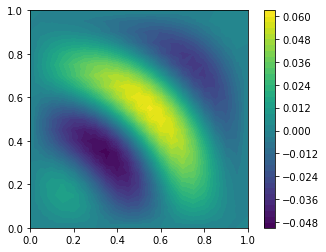

In [41]:
m_reconstructed = Function(V)
m_reconstructed.vector()[:] = soln.x
cm1 = plot(m_reconstructed)
plt.colorbar(cm1)

plt.figure()
cm2 = plot(m_true, mesh=mesh)
plt.colorbar(cm2)